# Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов

# Тариф «Смарт»
    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета: 
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей


# Тариф «Ультра»

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

# Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Предобработка данных

    Приведите данные к нужным типам.
    Найдите и исправьте ошибки в данных, если они есть.
    Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. 
    Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

В данном разделе было выполнено следующее:
    
1. Удален ненужный столбец в датасете internet;
    
2. Изменен формат значений даты в нескольких датасетах на временной;
    
3. В датасете users в столбце "дата прекращения" обнаружены пропуски, которые, согласно легенде,говорят о том, что тарифом пользовались на момент составления датасета - оставил без изменений
    



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math 
import scipy.stats as st
import random

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [5]:
# Есть ненужный столбец, можно от него избавиться
internet = internet.drop(['Unnamed: 0'], axis=1)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [6]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [9]:
# Изменим формат столбцов с датами на временной:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [10]:
for data in (calls, internet, messages, tariffs, users):
    print(data.info(), end='\n\n' )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB
None

<class 'pand

In [11]:
# Проверим наличие пропусков
for data in (calls, internet, messages, tariffs, users):
    print(data.isna().sum(), end='\n\n')

id           0
call_date    0
duration     0
user_id      0
dtype: int64

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

id              0
message_date    0
user_id         0
dtype: int64

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64



Пропуски в churn_date - пропущенные звонки - оставил без изменения, как и было указано в описании проекта

In [12]:
# проверка на дубликаты
for data in (calls, internet, messages, tariffs, users):
    print(data.duplicated().sum())

0
0
0
0
0


In [13]:
# Рассмотрим данные потребления трафика
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [14]:
internet['mb_used'].value_counts()

0.00      19598
335.91        9
447.30        9
197.56        9
199.11        8
          ...  
182.69        1
726.03        1
315.12        1
898.99        1
677.66        1
Name: mb_used, Length: 70003, dtype: int64

<AxesSubplot:>

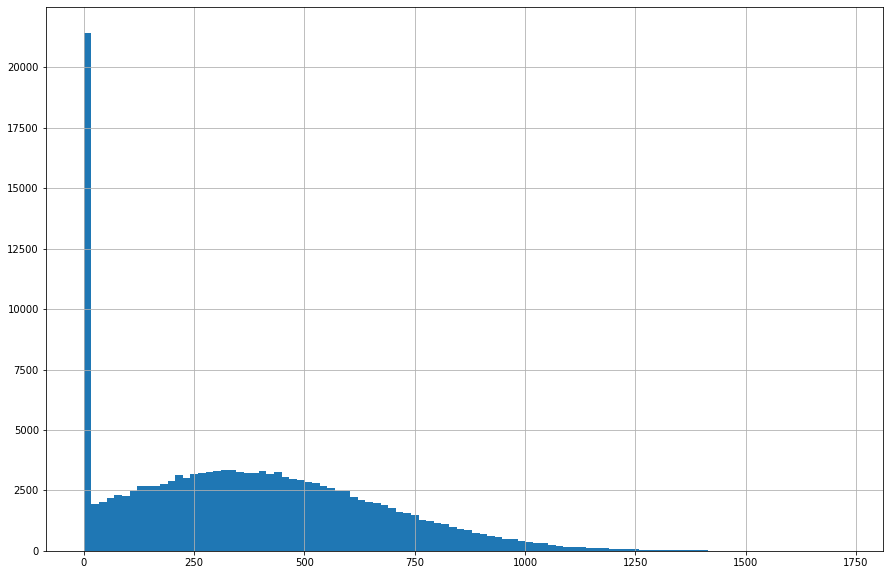

In [15]:
internet['mb_used'].hist(bins=100, figsize=(15,10))

In [59]:
zero_internet_ratio = len(internet[internet['mb_used']==0])/len(internet['mb_used'])
zero_internet_ratio

0.13118155773916304

В ходе рассмотрения данных потребления интернета было выявлено определенное количество нулевых значений = 13% от общего количества интернет-сессий. В данном исследовании, на мой взгляд, их можно оставить без изменений, так как они не влияют на общую цель проекта - исследование экономической эффективности тарифов, потому что определенный объем интернет-трафика уже включен в тарифный план. 

## Посчитайте для каждого пользователя:

    - количество сделанных звонков и израсходованных минут разговора по месяцам;
    - количество отправленных сообщений по месяцам;
    - объем израсходованного интернет-трафика по месяцам;
    - помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков,
    сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату,
    соответствующую тарифному плану).

In [17]:
# Выделим отдельный столбец для месяцев:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

In [18]:
# Округлим значения длительности звонков до верхнего:
# Исправил использование метода np.ceil - без apply
# calls('duration_round') = calls('duration').apply(np.ceil)
calls['duration_round'] = np.ceil(calls['duration'])
calls['duration_round'].head()

0     0.0
1     0.0
2     3.0
3    14.0
4     6.0
Name: duration_round, dtype: float64

In [60]:
# Создадим отдельные таблицы для звонков, сообщений, интернета и потом объединим их:
calls_info = calls.pivot_table(index=['user_id', 'month'], values='duration_round', aggfunc=('sum', 'count'))
calls_info.columns = ['calls', 'duration']
calls_info.head()

calls  duration
user_id month                 
1000    5         22     159.0
        6         43     172.0
        7         47     340.0
        8         52     408.0
        9         58     466.0

In [20]:
messages_info = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_info.columns=['messages']
messages_info.head()


messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57

In [21]:
internet_info = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_info.columns=['mb_used']
internet_info.head()

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91

In [22]:
# Объединим три таблицы с помощью functools.reduce (загуглил как это делается)
from functools import reduce
data_frames = [calls_info, messages_info, internet_info]
user_data = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), data_frames)
user_data = user_data.reset_index()
user_data.head()

,user_id,month,calls,duration,messages,mb_used
0,1000,5,22.0,159.0,22.0,2253.49
1,1000,6,43.0,172.0,60.0,23233.77
2,1000,7,47.0,340.0,75.0,14003.64
3,1000,8,52.0,408.0,81.0,14055.93
4,1000,9,58.0,466.0,57.0,14568.91


In [23]:
user_data['user_id'].value_counts()

1372    12
1227    12
1135    12
1472    12
1134    12
        ..
1140     1
1434     1
1297     1
1252     1
1445     1
Name: user_id, Length: 498, dtype: int64

In [24]:
user_data.isna().sum()

user_id       0
month         0
calls        40
duration     40
messages    497
mb_used      11
dtype: int64

В этой таблице у нас есть пропуски, которые в дальнейшем могут повлиять на расчет выручки с каждого пользователя. Большое количество пропусков в messages можно объяснить тем, что сейчас пользователи практически не пишут смс. Все пропуски можно заменить на 0, так как мы в любом случае не знаем, тратили ли пользователи сверх пакета или нет, и для выручки мы примем в расчет только абонентскую плату по тарифу. 

In [25]:
user_data = user_data.fillna(0)
user_data.isna().sum()

user_id     0
month       0
calls       0
duration    0
messages    0
mb_used     0
dtype: int64

In [26]:
# Создадим отдельный столбец для использованных Гб
# Округлим полученные значения мегабайт до верхнего
# user_data['gb_used'] = user_data['mb_used']/1024.apply(np.ceil)
user_data['gb_used'] = np.ceil(user_data['mb_used']/1024)
user_data.head()

,user_id,month,calls,duration,messages,mb_used,gb_used
0,1000,5,22.0,159.0,22.0,2253.49,3.0
1,1000,6,43.0,172.0,60.0,23233.77,23.0
2,1000,7,47.0,340.0,75.0,14003.64,14.0
3,1000,8,52.0,408.0,81.0,14055.93,14.0
4,1000,9,58.0,466.0,57.0,14568.91,15.0


In [27]:
user_data['user_id'].value_counts()

1372    12
1227    12
1135    12
1472    12
1134    12
        ..
1140     1
1434     1
1297     1
1252     1
1445     1
Name: user_id, Length: 498, dtype: int64

In [28]:
# Добавим столбец с названием тарифа
tariff = pd.DataFrame()
tariff = users[['user_id', 'tariff']]
user_data = user_data.merge(tariff)
user_data.head()

,user_id,month,calls,duration,messages,mb_used,gb_used,tariff
0,1000,5,22.0,159.0,22.0,2253.49,3.0,ultra
1,1000,6,43.0,172.0,60.0,23233.77,23.0,ultra
2,1000,7,47.0,340.0,75.0,14003.64,14.0,ultra
3,1000,8,52.0,408.0,81.0,14055.93,14.0,ultra
4,1000,9,58.0,466.0,57.0,14568.91,15.0,ultra


In [29]:
user_data['user_id'].value_counts()

1372    12
1227    12
1135    12
1472    12
1134    12
        ..
1140     1
1434     1
1297     1
1252     1
1445     1
Name: user_id, Length: 498, dtype: int64

In [30]:
# Добавим столбец с Гб в датасет "tariffs"
tariffs['gb_included'] = tariffs['mb_per_month_included']/1024
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


In [31]:
# Создадим функцию для расчета выручки каждого пользователя с учетом абонентской платы по тарифу

user_data['revenue'] = ''

def revenue(row):
    if row['tariff'] == "ultra":
        extra_duration = row['duration'] - tariffs.loc[1, 'minutes_included']
        extra_gb = row['gb_used'] - tariffs.loc[1, 'gb_included']
        extra_messages = row['messages'] - tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: 
            extra_duration = 0
        if extra_gb < 0: 
            extra_gb = 0
        if extra_messages < 0: 
            extra_messages = 0
        
        return (
            tariffs.loc[1, 'rub_per_message']*extra_messages 
            + tariffs.loc[1, 'rub_per_gb']*extra_gb 
            + tariffs.loc[1, 'rub_per_minute']*extra_duration 
            + tariffs.loc[1, 'rub_monthly_fee']
        )
    else:
        extra_duration = row['duration'] - tariffs.loc[0, 'minutes_included']
        extra_gb = row['gb_used'] - tariffs.loc[0, 'gb_included']
        extra_messages = row['messages'] - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: 
            extra_duration = 0
        if extra_gb < 0: 
            extra_gb = 0
        if extra_messages < 0: 
            extra_messages = 0
        
        return (
            tariffs.loc[0, 'rub_per_message']*extra_messages 
            + tariffs.loc[0, 'rub_per_gb']*extra_gb 
            + tariffs.loc[0, 'rub_per_minute']*extra_duration 
            + tariffs.loc[0, 'rub_monthly_fee']
        )

user_data['revenue'] = user_data.apply(revenue, axis=1)
user_data.head()
       
   


,user_id,month,calls,duration,messages,mb_used,gb_used,tariff,revenue
0,1000,5,22.0,159.0,22.0,2253.49,3.0,ultra,1950.0
1,1000,6,43.0,172.0,60.0,23233.77,23.0,ultra,1950.0
2,1000,7,47.0,340.0,75.0,14003.64,14.0,ultra,1950.0
3,1000,8,52.0,408.0,81.0,14055.93,14.0,ultra,1950.0
4,1000,9,58.0,466.0,57.0,14568.91,15.0,ultra,1950.0


In [32]:
# Комментарий ревьюера
user_data.user_id.unique().shape 

(498,)

In [33]:
list_of_users = set(user_data['user_id'].unique().tolist())
id_numbers =set(np.arange(1000,1500,1).tolist())
print(list(id_numbers-list_of_users))

[1128, 1371]


In [34]:
for data in (calls, internet, messages, users):
    print(data.query('user_id==1128 or user_id==1371'))


Empty DataFrame
Columns: [id, call_date, duration, user_id, month, duration_round]
Index: []
Empty DataFrame
Columns: [id, mb_used, session_date, user_id, month]
Index: []
Empty DataFrame
Columns: [id, message_date, user_id, month]
Index: []
     user_id  age churn_date      city first_name last_name   reg_date tariff
128     1128   51 2018-12-23  Волжский     Ксения    Агаева 2018-12-15  ultra
371     1371   50 2018-12-30      Омск     Ириней  Трофимов 2018-12-25  smart


В ходе проверки выяснилось, что пропавшие два пользователя (по одному на каждый исследуемый тариф) не попали в отфильтрованную таблицу, потому что абоненты совсем не пользовались мобильной связью/интернетом/сообщениями, и отказались от данного тарифа практически уже через неделю. Также мы не можем с уверенностью сказать, была ли списана у данных пользователей абонентская плата за тариф - возможно тариф и был аннулирован за неуплату. Поэтому мы не можем добавить их в расчет выручки.

## Проанализируйте данные
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [35]:
# Посчитаем, сколько в среднем каждому пользователю требуется минут, сообщений и мегабайт в месяц. 
# Для описания лучше использовать медиану, но можно посчитать оба показателя (медиана и средняя)
users_monthly = user_data.pivot_table(index=['user_id', 'tariff'], values=['duration', 'messages', 'gb_used'], aggfunc=['mean', 'median'])
users_monthly = users_monthly.reset_index()
users_monthly.head()

user_id tariff        mean                       median                 
                    duration    gb_used messages duration gb_used messages
0    1000  ultra  320.750000  13.625000     62.0    339.0    14.5     65.0
1    1001  smart  422.000000  16.000000      0.0    422.0    16.0      0.0
2    1002  smart  216.714286  16.714286     10.0    214.0    18.0     11.0
3    1003  ultra  764.400000  11.800000     76.0    824.0    12.0     83.0
4    1004  ultra  123.375000  18.750000    149.0    132.5    18.0    154.5

In [36]:
# Выделим отдельные таблицы с пользователями разных тарифов
smart_users = user_data.query('tariff=="smart"')
smart_users.head()

,user_id,month,calls,duration,messages,mb_used,gb_used,tariff,revenue
8,1001,11,59.0,430.0,0.0,18429.34,18.0,smart,1150.0
9,1001,12,63.0,414.0,0.0,14036.66,14.0,smart,550.0
10,1002,6,15.0,117.0,4.0,10856.82,11.0,smart,550.0
11,1002,7,26.0,214.0,11.0,17580.10,18.0,smart,1150.0
12,1002,8,42.0,289.0,13.0,20319.26,20.0,smart,1550.0


In [37]:
smart_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 8 to 3213
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   2229 non-null   int64  
 1   month     2229 non-null   int64  
 2   calls     2229 non-null   float64
 3   duration  2229 non-null   float64
 4   messages  2229 non-null   float64
 5   mb_used   2229 non-null   float64
 6   gb_used   2229 non-null   float64
 7   tariff    2229 non-null   object 
 8   revenue   2229 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 174.1+ KB


In [38]:
smart_users['revenue'].value_counts()

550.0     567
950.0      87
1150.0     80
1350.0     78
750.0      71
         ... 
1073.0      1
888.0       1
1158.0      1
3985.0      1
912.0       1
Name: revenue, Length: 767, dtype: int64

In [39]:
ultra_users = user_data.query('tariff=="ultra"')
ultra_users.head()

,user_id,month,calls,duration,messages,mb_used,gb_used,tariff,revenue
0,1000,5,22.0,159.0,22.0,2253.49,3.0,ultra,1950.0
1,1000,6,43.0,172.0,60.0,23233.77,23.0,ultra,1950.0
2,1000,7,47.0,340.0,75.0,14003.64,14.0,ultra,1950.0
3,1000,8,52.0,408.0,81.0,14055.93,14.0,ultra,1950.0
4,1000,9,58.0,466.0,57.0,14568.91,15.0,ultra,1950.0


In [40]:
ultra_users['revenue'].value_counts()

1950.0    851
2250.0     21
2400.0     18
2550.0     13
2100.0     12
3000.0     10
2700.0     10
3150.0      9
3750.0      9
3300.0      9
2850.0      7
3900.0      6
3450.0      4
3600.0      2
4200.0      1
4800.0      1
4050.0      1
4650.0      1
Name: revenue, dtype: int64

In [41]:
# Посчитаем, сколько в среднем расходуют пользователи тарифов "Смарт и "Ультра"  
median = user_data.pivot_table(
    index='tariff', values=['duration', 'messages', 'gb_used', 'revenue'], aggfunc='median')
median

,duration,gb_used,messages,revenue
tariff,,,,
smart,422.0,17.0,28.0,1023.0
ultra,518.0,19.0,38.0,1950.0


Видно, что пользователям тарифа "Смарт" не хватает предоставленных 15 Гб трафика

In [42]:
# Посчитаем статистические показатели
variation = user_data.pivot_table(
    index='tariff', values=['duration', 'messages', 'gb_used'], aggfunc=np.var)
variation

,duration,gb_used,messages
tariff,,,
smart,36219.315784,33.028705,796.812958
ultra,100873.633397,97.091686,2285.266143


In [43]:
standard_deviation = user_data.pivot_table(
    index='tariff', values=['duration', 'messages', 'gb_used'], aggfunc=np.std)
standard_deviation

,duration,gb_used,messages
tariff,,,
smart,190.313730,5.747061,28.227876
ultra,317.606098,9.853511,47.804457


In [44]:
user_stats = user_data.pivot_table(
    index='tariff', values=['duration', 'messages', 'gb_used'], aggfunc=['mean', np.var, np.std])
user_stats

mean                                  var             \
          duration    gb_used   messages       duration    gb_used   
tariff                                                               
smart   417.934948  16.328847  33.384029   36219.315784  33.028705   
ultra   526.623350  19.494416  49.363452  100873.633397  97.091686   

                            std                       
           messages    duration   gb_used   messages  
tariff                                                
smart    796.812958  190.313730  5.747061  28.227876  
ultra   2285.266143  317.606098  9.853511  47.804457

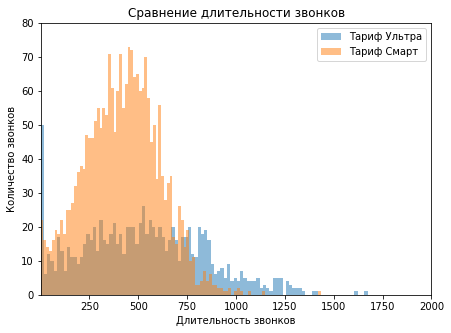

In [45]:
plt.figure(figsize=(7,5))
plt.hist(ultra_users['duration'], bins=100, alpha=0.5, label="Тариф Ультра")
plt.hist(smart_users['duration'], bins=100, alpha=0.5, label="Тариф Смарт")
plt.ylim(0, 80)
plt.xlim(1, 2000) 
plt.xlabel("Длительность звонков", size=10)
plt.ylabel("Количество звонков", size=10)
plt.title("Сравнение длительности звонков")
plt.legend(loc='upper right')

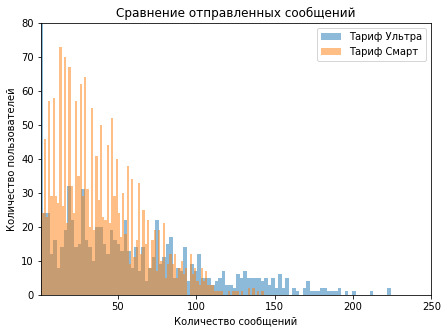

In [46]:
plt.figure(figsize=(7,5))
plt.hist(ultra_users['messages'], bins=100, alpha=0.5, label="Тариф Ультра")
plt.hist(smart_users['messages'], bins=100, alpha=0.5, label="Тариф Смарт")
plt.ylim(0, 80)
plt.xlim(1, 250) 
plt.xlabel("Количество сообщений", size=10)
plt.ylabel("Количество пользователей", size=10)
plt.title("Сравнение отправленных сообщений")
plt.legend(loc='upper right')

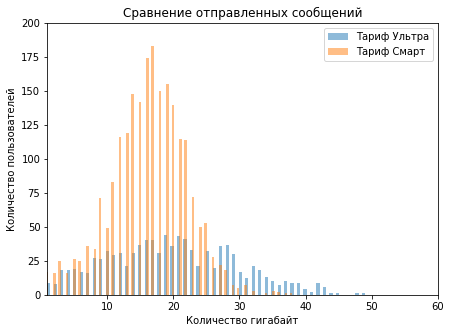

In [47]:
plt.figure(figsize=(7,5))
plt.hist(ultra_users['gb_used'], bins=100, alpha=0.5, label="Тариф Ультра")
plt.hist(smart_users['gb_used'], bins=100, alpha=0.5, label="Тариф Смарт")
plt.ylim(0, 200)
plt.xlim(1, 60) 
plt.xlabel("Количество гигабайт", size=10)
plt.ylabel("Количество пользователей", size=10)
plt.title("Сравнение отправленных сообщений")
plt.legend(loc='upper right')

  Гистограммы по длительности звонков и интернет-трафику показывают нормальное распределение, по количеству использованных сообщений можем наблюдать распределение Пирсона. Выделяются нулевые выбросы в длительности - показывают пропущенные звонки, и в сообщениях. Они не влияют на распределение.
    
  Что касается статистических показателей, то если средние значения пользователей тарифов "Смарт" и "Ультра" нет так сильно различаются, то по таким показателям как стандартное отклонение и дисперсия разница существенная по все категориям (длительность звонков, сообщения, интернет). Это можно объяснить тем, что пользователи более дорогого тарифа "Ультра", имея бОльшие лимиты по услугам, чувствуют себя свободней в использовании той или иной услуги, и их поведение гораздо разнообразней. В тоже время, пользователям тарифа "Смарт" явно не хватает предоставленных в рамках пакета минут и интернета. 

In [48]:
# Посчитаем статистические показатели для выручки
revenue_stats = user_data.pivot_table(
    index='tariff', values=['revenue'], aggfunc=['mean', 'median', np.var, np.std])
revenue_stats

,mean,median,var,std
,revenue,revenue,revenue,revenue
tariff,,,,
smart,1289.973531,1023.0,669785.708006,818.404367
ultra,2070.152284,1950.0,141516.745079,376.187114


In [49]:
# Ежемесячная выручка и количество пользователей по тарифам
monthly_users_revenue = user_data.pivot_table(
    index=['tariff', 'month'], values=['user_id', 'revenue'], aggfunc={'user_id':'count', 'revenue':'sum'}
).reset_index()
monthly_users_revenue.rename(columns={'user_id':'active_users'}, inplace=True)
monthly_users_revenue

,tariff,month,revenue,active_users
0,smart,1,24525.0,34
1,smart,2,48001.0,58
2,smart,3,89676.0,77
3,smart,4,107866.0,112
4,smart,5,168849.0,141
5,smart,6,197459.0,164
6,smart,7,246014.0,201
7,smart,8,310340.0,235
8,smart,9,324986.0,260
9,smart,10,401267.0,294


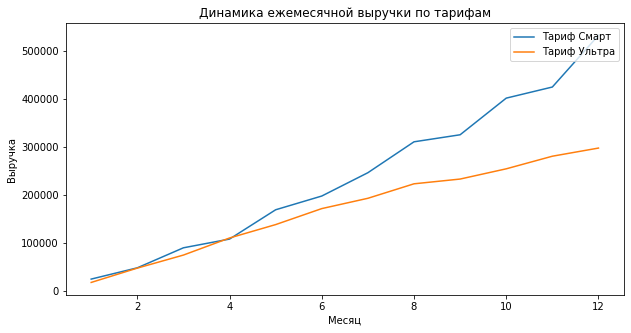

In [50]:
plt.figure(figsize=(10,5))
x1 = monthly_users_revenue[monthly_users_revenue['tariff']=='smart']['month']
y1 = monthly_users_revenue[monthly_users_revenue['tariff']=='smart']['revenue']
x2 = monthly_users_revenue[monthly_users_revenue['tariff']=='ultra']['month']
y2 = monthly_users_revenue[monthly_users_revenue['tariff']=='ultra']['revenue']
plt.plot(x1, y1, label="Тариф Смарт")
plt.plot(x2, y2, label="Тариф Ультра")
plt.xlabel("Месяц", size=10)
plt.ylabel("Выручка", size=10)
plt.title("Динамика ежемесячной выручки по тарифам")
plt.legend(loc='upper right')

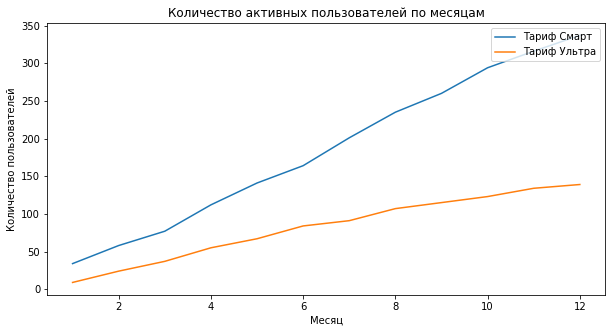

In [51]:
plt.figure(figsize=(10,5))
x1 = monthly_users_revenue[monthly_users_revenue['tariff']=='smart']['month']
y1 = monthly_users_revenue[monthly_users_revenue['tariff']=='smart']['active_users']
x2 = monthly_users_revenue[monthly_users_revenue['tariff']=='ultra']['month']
y2 = monthly_users_revenue[monthly_users_revenue['tariff']=='ultra']['active_users']
plt.plot(x1, y1, label="Тариф Смарт")
plt.plot(x2, y2, label="Тариф Ультра")
plt.xlabel("Месяц", size=10)
plt.ylabel("Количество пользователей", size=10)
plt.title("Количество активных пользователей по месяцам")
plt.legend(loc='upper right')

<AxesSubplot:>

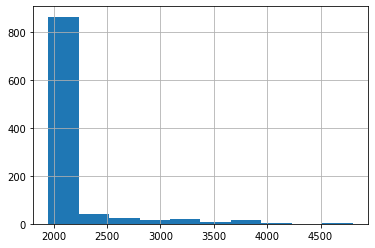

In [52]:
ultra_users['revenue'].hist()

<AxesSubplot:>

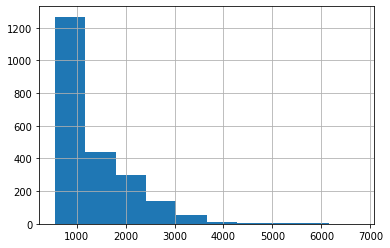

In [53]:
smart_users['revenue'].hist()

Анализ выручки по тарифам показал более спокойное и пресдказуемое "поведение" пользователей дорогого тарифа "Ультра" - основная часть выручки приходится на стандартную стоимость тарифа (1950 руб). Пользователи тарифа "Смарт" платят больше стоимости тарифа - практически в два раза. При этом стоит отметить что пользователи не отказываются от дешевого тарифа в пользу дорогого. Мы не видим тенденции снижения роста количества пользователей по обоим тарифам, но рост пользователей тарифа Смарт в течение года больше, чем рост пользователей Ультра.

## Проверьте гипотезы
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сформулируем гипотезы следующим образом:
            
- Н0: Средняя выручка пользователей тарифа "Смарт" равна средней выручке пользователей тарифа "Ультра"
- Н1: Средняя выручка пользователей тарифа "Смарт" и тарифа "Ультра" различаются
    
    
- Н0: Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов
- Н1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

В данном случае используем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей: scipy.stats.ttest_ind() 

In [54]:
# Для удобства добавим столбец "Город" в таблицу
city = pd.DataFrame()
city = users[['user_id', 'city']]
user_data = user_data.merge(city)
user_data.head()

,user_id,month,calls,duration,messages,mb_used,gb_used,tariff,revenue,city
0,1000,5,22.0,159.0,22.0,2253.49,3.0,ultra,1950.0,Краснодар
1,1000,6,43.0,172.0,60.0,23233.77,23.0,ultra,1950.0,Краснодар
2,1000,7,47.0,340.0,75.0,14003.64,14.0,ultra,1950.0,Краснодар
3,1000,8,52.0,408.0,81.0,14055.93,14.0,ultra,1950.0,Краснодар
4,1000,9,58.0,466.0,57.0,14568.91,15.0,ultra,1950.0,Краснодар


In [55]:
# Н0: Средняя выручка пользователей тарифа "Смарт" равна средней выручке пользователей тарифа "Ультра"
# Н1: Средняя выручка пользователей тарифа "Смарт" и тарифа "Ультра" различаются

smart = smart_users['revenue']
ultra = ultra_users['revenue']

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(smart, ultra, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


In [56]:
tariff_revenue = user_data.pivot_table(index='tariff', values='revenue', aggfunc=['mean', 'median'])
tariff_revenue

,mean,median
,revenue,revenue
tariff,,
smart,1289.973531,1023.0
ultra,2070.152284,1950.0


Гипотеза о том, что средняя выручка пользователей тарифа "Смарт" равна средней выручке пользователей тарифа "Ультра", не подтвердилась. Средние значения выручки по тарифам различаются почти в 2 раза. Пользователи тарифа "Смарт" с абонентской платой в 550 рублей платят гораздо больше из-за нехватки услуг в рамках тарифного пакета. 

In [57]:
# Н0: Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов
# Н1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

moscow = user_data.query('city=="Москва"')['revenue']
regions = user_data.query('city!="Москва"')['revenue']

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(moscow, regions, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


In [58]:
def region(city):
    if city == 'Москва': 
        return 'Москва'
    else: 
        return 'Другой регион'
    
user_data['region'] = user_data['city'].apply(region)
user_data.pivot_table(index='region', values='revenue', aggfunc='median')

,revenue
region,
Другой регион,1583.0
Москва,1750.0


На основе полученных данных мы не можем опровергнуть гипотезу, что средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. 

## Напишите общий вывод

Анализ показал, что пользователям тарифа "Смарт" не хватает включенных в тариф лимитов на услуги, особенно предоставляемых 15Гб интернета: в среднем тратят 17Гб, в то время как пользователи тарифа "Ультра" не испытывают недостатка предоставляемых в рамках тарифа услуг. Более того, по средним показателям видно, что они расходуют гораздо меньше пакета (518 минут из 1000, 19Гб из 30), компании "Мегалайн" можно задуматься об урезании лимитов на услуги. Незначительное использование предоставляемых сообщений (СМС) в обоих тарифах говорит о снижении популярности данной услуги в целом. 
  
В среднем пользователи дешевого тарифа " переплачивают в 2 раза больше абонентской платы (1023 руб. против 550 руб.). Учитывая перерасход интернета в среднем на 2Гб при стоимости 200 руб за каждый гигабайт сверх пакета, получаем дополнительные 400 руб в месяц. Средняя выручка с каждого пользователя "Ультра" составляет 1950 рублей - это абонентская плата за тариф. 
 
Нельзя утверждать, что а) выручка от пользователей данных тарифов одинаковая (средние значения 1023 и 1950 отличаются почти в два раза) и б) выручка от московских пользователей отличается от пользователей в других регионах (1750 в Москве и 1583 для других регионов - незначительная разница).

С точки зрения экономической эффективности, то за исследуемый период оба тарифа показали устойчивый рост количества новых пользователей, причем люди гораздо охотнее подключаются к дешевому тарифу. Анализ показывает, что несмотря на то что им не хватает включенных в пакет услуг и приходится переплачивать, пользователи при этом все равно платят меньше фиксированной платы дорогого тарифа Ультра (1023 против 1950 руб.). Соответственно, дешевый тариф более экономически эффективен для компании. 
    
